In [1]:
%%time
import datamapplot as dmp
import duckdb
from fast_hdbscan import HDBSCAN
import glasbey as gb
from hashlib import md5
import joblib as jl
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import shlex
from sklearn.decomposition import TruncatedSVD
from tqdm.auto import tqdm
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
from vectorizers.utils import procrustes_align

import eng.bpe

CPU times: user 19.8 s, sys: 858 ms, total: 20.6 s
Wall time: 20.8 s


In [2]:
tqdm.pandas()

Get the data from here: https://gdo168.llnl.gov/data/ACME-2023/stdview-20231105-20231120.tar

In [3]:
db = duckdb.connect(":memory:")

In [4]:
%load_ext magic_duckdb
%dql -co db

In [5]:
for table in ["process", "process_path", "process_image_load"]:
    db.execute(f"create or replace view {table} as select * from parquet_scan('/data/acme3/stdview-20231105-20231120/{table}.parquet')")

Drop the processes involved with the Amazon and Wintap agents.

In [6]:
%%dql
describe process

,column_name,column_type,null,key,default,extra
0,pid_hash,VARCHAR,YES,None,None,None
1,os_family,VARCHAR,YES,None,None,None
2,agent_id,VARCHAR,YES,None,None,None
3,num_agent_id,BIGINT,YES,None,None,None
4,hostname,VARCHAR,YES,None,None,None
5,os_pid,INTEGER,YES,None,None,None
6,process_name,VARCHAR,YES,None,None,None
7,num_process_name,BIGINT,YES,None,None,None
8,args,VARCHAR,YES,None,None,None
9,num_args,BIGINT,YES,None,None,None


In [7]:
db.execute(
    """
    create or replace view process_interesting as
    select process.*, process_path.ptree as ptree
    from process
    inner join process_path using (pid_hash)
    where process_path.ptree not like '%wintap%' and process_path.ptree not like '%amazon-ssm%'
    and process_started >= '2023-11-05'::timestamp
    and process_started = first_seen
    """
)

Here are the _interesting_ processes:

In [8]:
%%time
metadata_interesting = db.execute(
    """
    select pid_hash, parent_pid_hash, process_name, process_path, args, ptree, hostname, process_started as timestamp
    from process_interesting
    order by pid_hash
    """
).df()
metadata_interesting

CPU times: user 5.68 s, sys: 2.53 s, total: 8.21 s
Wall time: 1.06 s


,pid_hash,parent_pid_hash,process_name,process_path,args,ptree,hostname,timestamp
0,0000283F736E630ABFCC5AA836DA8DE6,6DB651F1EAD84F88801332945F69A5F2,rundll32.exe,c:\windows\system32\rundll32.exe,c:\windows\system32\windows.staterepositorycli...,=rundll32.exe->svchost.exe->services.exe->wini...,ACME-HH-TTW,2023-11-08 14:15:49.683641+00:00
1,000057E3B323CF730E68A978E00E8E53,C991863B4324678B5FF92D1A04E11CF4,mergehelper.exe,c:\program files\wintap\mergertool\mergehelper...,c:\programdata\wintap\parquet\default_sensor\m...,=mergehelper.exe->smss.exe->smss.exe->ntoskrnl...,ACME-WS-PLU,2023-11-09 11:47:37.440153+00:00
2,0000ED740D89D0FD67FEDD3A460D1233,E1BB141B4D041B0485BCA35B4A52725F,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 224 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-NUQ,2023-11-09 20:09:39.039176+00:00
3,00011F5A487D54C57AD3D7B5CF49B8D6,853E6A28F9CDE865C4D761475F2FE6DB,dsregcmd.exe,c:\windows\system32\dsregcmd.exe,$(arg0) $(arg1) $(arg2),=dsregcmd.exe->svchost.exe->services.exe->wini...,ACME-HH-AKA,2023-11-17 06:52:59.176362+00:00
4,0001A7D9420F65F0E8B07E78E1D26B45,5319246012A53BB36BAC5DBDA231D7B0,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...,ACME-HH-HGC,2023-11-17 18:27:54.370126+00:00
...,...,...,...,...,...,...,...,...
137842,FFFD4487BC268AEDAF4460E91D9EA109,4513F1678CB5D6E0E95F95DA0ECB2E2D,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...,ACME-WS-PRV,2023-11-05 09:20:00.219223+00:00
137843,FFFE1903C27DA29570F2E06FF02ECD95,269548B3623B541DD38D6B73AFAC2244,msedge.exe,c:\program files (x86)\microsoft\edge\applicat...,--type=renderer --disable-nacl --disable-gpu-c...,=msedge.exe->na.exe->ntoskrnl.exe,ACME-DC1,2023-11-05 21:21:20.362937+00:00
137844,FFFE89C9D856A2CA183895879FD210E0,CC4EFBD4A491E06FB568D3BE2A7F3DA8,svchost.exe,c:\windows\system32\svchost.exe,-k netsvcs -p -s netsetupsvc,=svchost.exe->services.exe->wininit.exe->smss....,ACME-HH-DFN,2023-11-16 21:01:01.242689+00:00
137845,FFFF1E20E3041AA26D33FB1C563C1AEF,381DD681D08B21CAA47EF823BB3AA8D1,python.exe,c:\users\user6\desktop\extend_bincfg\.venv\scr...,"""c:\users\user6\desktop\extend_bincfg\.venv\sc...",=python.exe->pip.exe->powershell.exe->code.exe...,ACME-HH-CCF,2023-11-07 17:30:42.087120+00:00


# Command line embedding

In [9]:
cmdlines = (
    metadata_interesting
    .assign(space=" ")[["process_path", "space", "args"]]
    .dropna(subset=["process_path"])
    .fillna("")
    .sum(axis=1)
    .str.strip()
    .str.encode("ascii", errors="backslashreplace")
    .str.decode("ascii")
)
cmdlines

0         c:\windows\system32\rundll32.exe c:\windows\sy...
1         c:\program files\wintap\mergertool\mergehelper...
2         c:\windows\microsoft.net\framework64\v4.0.3031...
3         c:\windows\system32\dsregcmd.exe $(arg0) $(arg...
4         c:\program files (x86)\microsoft\edgeupdate\mi...
                                ...                        
137842    c:\program files (x86)\microsoft\edgeupdate\mi...
137843    c:\program files (x86)\microsoft\edge\applicat...
137844    c:\windows\system32\svchost.exe -k netsvcs -p ...
137845    c:\users\user6\desktop\extend_bincfg\.venv\scr...
137846    c:\windows\system32\backgroundtaskhost.exe -se...
Length: 137847, dtype: object

In [10]:
cmdlines_u, i_unique, i_deunique, cmdline_counts = np.unique(cmdlines, return_index=True, return_inverse=True, return_counts=True)
cmdlines_u.shape

(31046,)

In [11]:
metadata_u = metadata_interesting.iloc[i_unique].copy().reset_index(drop=True)
metadata_u

,pid_hash,parent_pid_hash,process_name,process_path,args,ptree,hostname,timestamp
0,45EBAFA4120EBD83795F91B021C2C987,AAF97101D35382DDB72DCD4FEE05818C,csrss.exe,%systemroot%\system32\csrss.exe,None,=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe,ACME-HH-AKA,2023-11-14 00:22:19.554954+00:00
1,03A4AD4CE884C4D2CB9CE23607E4A35E,335D6A59E07FC78DE64768014933B6CB,csrss.exe,%systemroot%\system32\csrss.exe,"objectdirectory=\windows sharedsection=1024,20...",=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe,ACME-HH-ATV,2023-11-08 16:01:37.414747+00:00
2,71A014969332AF0C1E0FBFC883BEB8FF,8A11985B996D25FAA8FC6F94A809E609,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4mihmtqkbeq8ipb4.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-IQS,2023-11-07 19:42:03.258287+00:00
3,83FB4E68D3AC8DA9B36A19FF158F9410,EB9FBBB61091C81393AE20E790E727E0,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4tajqs4wkk6kfb/j.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-AZH,2023-11-14 04:48:15.658330+00:00
4,A5F0F3DB7F64C157C48A7CCBFDCCB9DD,B2DD3FB8C188BC146EECC8FDACD9AAAB,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4uqlwvfixukjkqzh.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-AKA,2023-11-14 16:36:33.696670+00:00
...,...,...,...,...,...,...,...,...
31041,02DB21D8ABE8F5A2469091D66C6862FD,2B69DF1A23610FC8D0E5F50A03883E05,bash.exe,usr\bin\bash.exe,"--norc -c ""export path=/usr/bin:$path; export ...",=bash.exe->bash.exe->cmd.exe->git-2.42.0.2-64-...,ACME-HH-CLR,2023-11-06 18:06:39.448223+00:00
31042,14D7595BC2FB5628AAB10551544BB9ED,37E1609DD5A275CD904E84C2857EC4F9,mintty.exe,usr\bin\mintty.exe,--nodaemon -o appid=gitforwindows.bash -o appl...,=mintty.exe->git-bash.exe->explorer.exe->useri...,ACME-HH-EAY,2023-11-08 21:41:57.108226+00:00
31043,0F614EC33E232A39E9363BC8E8B5717D,A2EEEEB8800FD1E7DA1C4593BB0C00AE,vboxheadless.exe,vboxheadless.exe,None,=vboxheadless.exe->vboxheadless.exe->vboxsvc.e...,ACME-HH-CCF,2023-11-07 16:57:03.203161+00:00
31044,73323197ECBC776B25F7554996E55495,DA246B2864851B5489A77B696F4E767B,vswhere.exe,vswhere.exe,-property catalog_productsemanticversion -path...,=vswhere.exe->cmd.exe->cmd.exe->powershell.exe...,ACME-HH-EAY,2023-11-07 19:30:14.549266+00:00


In [20]:
vz_bpe = vz.BytePairEncodingVectorizer(max_vocab_size=600).fit(cmdlines_u.tolist())
[longest for longest in sorted(vz_bpe.tokens_, key=len, reverse=True)][75:100]

['\\v4.0.30319\\mscorsvw.exe -',
 ' --disable-gpu-compositing',
 ' --enable-main-frame-befor',
 'c:\\windows\\microsoft.net\\',
 ' --lang=en-us --service-s',
 ' --time-ticks-at-unix-epo',
 ' --mojo-platform-channel',
 ' --field-trial-handle=19',
 ' --device-scale-factor=1',
 'c:\\program files\\wintap',
 ' --time-ticks-at-unix-e',
 'c:\\windows\\microsoft.n',
 'tevent 0 -ngenprocess ',
 'c:\\program files (x86)',
 ' --field-trial-handle=',
 ' --lang=en-us --servic',
 ' --num-raster-threads=',
 ' --renderer-client-id=',
 ' --disable-gpu-composi',
 '"ngen worker process"',
 'c:\\program files (x86',
 'device-scale-factor=1',
 ' --launch-time-ticks=',
 ' --time-ticks-at-unix',
 ' --enable-main-frame-']

In [21]:
%%time
cmdlines_vec = vz.BytePairEncodingVectorizer(max_vocab_size=600).fit_transform(cmdlines_u.tolist())
cmdlines_vec

CPU times: user 7.95 s, sys: 56.8 ms, total: 8.01 s
Wall time: 7.98 s


<31046x574 sparse matrix of type '<class 'numpy.float32'>'
	with 823621 stored elements in Compressed Sparse Row format>

In [22]:
%%time
cmdlines_vec_dmap = umap.UMAP(
    n_neighbors=50,
    metric="hellinger",
    n_epochs=500,
    verbose=True
).fit_transform(cmdlines_vec)

UMAP(angular_rp_forest=True, metric='hellinger', n_epochs=500, n_neighbors=50, verbose=True)
Thu Jul  4 13:53:04 2024 Construct fuzzy simplicial set
Thu Jul  4 13:53:04 2024 Finding Nearest Neighbors
Thu Jul  4 13:53:04 2024 Building RP forest with 14 trees
Thu Jul  4 13:53:08 2024 metric NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Thu Jul  4 13:55:10 2024 Finished Nearest Neighbor Search
Thu Jul  4 13:55:12 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 13:55:51 2024 Finished embedding
CPU times: user 26min 32s, sys: 24min 4s, total: 50min 36s
Wall time: 2min 46s


In [69]:
%%time
cmdlines_iwt = vzt.InformationWeightTransformer().fit_transform(cmdlines_vec)#[i_deunique])[i_unique, :]
cmdlines_iwt

CPU times: user 61 ms, sys: 0 ns, total: 61 ms
Wall time: 20.4 ms


<31046x574 sparse matrix of type '<class 'numpy.float64'>'
	with 823621 stored elements in Compressed Sparse Row format>

In [70]:
%%time
cmdlines_iwt_dmap = umap.UMAP(
    n_neighbors=50,
    metric="hellinger",
    init=cmdlines_vec_dmap,
    n_epochs=500,
    verbose=True
).fit_transform(cmdlines_iwt)

UMAP(angular_rp_forest=True, init=array([[15.1762085, 5.370199 ],
       [11.240554 , 8.210229 ],
       [15.740058 , 11.627251 ],
       ...,
       [13.332213 , 10.535676 ],
       [ 9.822349 , 10.004002 ],
       [12.980516 , 9.421767 ]], dtype=float32), metric='hellinger', n_epochs=500, n_neighbors=50, verbose=True)
Thu Jul  4 14:20:03 2024 Construct fuzzy simplicial set
Thu Jul  4 14:20:03 2024 Finding Nearest Neighbors
Thu Jul  4 14:20:03 2024 Building RP forest with 14 trees
Thu Jul  4 14:20:04 2024 metric NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Thu Jul  4 14:22:46 2024 Finished Nearest Neighbor Search
Thu Jul  4 14:22:47 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 14:23:28 2024 Finished embedding
CPU times: user 28min 4s, sys: 41min 44s, total: 1h 9min 49s
Wall time: 3min 25s


---

In [12]:
mscorsvw = metadata_u.loc[metadata_u["process_name"] == "mscorsvw.exe"]
mscorsvw

,pid_hash,parent_pid_hash,process_name,process_path,args,ptree,hostname,timestamp
16668,B9F748170B98B9226E0495F1757FBAC8,E1BB141B4D041B0485BCA35B4A52725F,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,None,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-NUQ,2023-11-09 20:24:31.573257+00:00
16669,C1DB5347DFA62A49FEADD676A140EC19,4CA458C46377DDE4FE02624458F10D49,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 1004 -interruptevent 0 -ngenproc...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 22:17:37.141284+00:00
16670,C5E8E608AD9C001144738A1F57E99FFB,4CA458C46377DDE4FE02624458F10D49,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 1004 -interruptevent 0 -ngenproc...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 22:17:37.204294+00:00
16671,67D87177730C9482B2F5FFC906E600F5,4CA458C46377DDE4FE02624458F10D49,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 101c -interruptevent 0 -ngenproc...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 22:17:37.057662+00:00
16672,B5E7287915CFD5969EE42CEA0DD81669,4CA458C46377DDE4FE02624458F10D49,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 101c -interruptevent 0 -ngenproc...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 22:17:37.810226+00:00
...,...,...,...,...,...,...,...,...
26311,8BB711AD8BD3B061E6B445D18C411E4C,B4E05F784C6F4DC31A4E2F223C45C4B9,mscorsvw.exe,c:\windows\microsoft.net\framework\v4.0.30319\...,-startupevent be4 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 21:45:59.320520+00:00
26312,DB150793145F58CDE06155B5D26F6061,B4E05F784C6F4DC31A4E2F223C45C4B9,mscorsvw.exe,c:\windows\microsoft.net\framework\v4.0.30319\...,-startupevent be4 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 21:45:58.969432+00:00
26313,A1F7D6CD5FA08B0F32AD102E1AF53E76,B4E05F784C6F4DC31A4E2F223C45C4B9,mscorsvw.exe,c:\windows\microsoft.net\framework\v4.0.30319\...,-startupevent bec -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 21:45:58.868682+00:00
26314,522393B9ED6C23052A16B53309328C11,B4E05F784C6F4DC31A4E2F223C45C4B9,mscorsvw.exe,c:\windows\microsoft.net\framework\v4.0.30319\...,-startupevent bf8 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-PRV,2023-11-10 21:45:59.224016+00:00


In [56]:
mscorsvw_cmdlines = pd.Series(cmdlines_u[mscorsvw.index])
mscorsvw_cmdlines

0       c:\windows\microsoft.net\framework64\v4.0.3031...
1       c:\windows\microsoft.net\framework64\v4.0.3031...
2       c:\windows\microsoft.net\framework64\v4.0.3031...
3       c:\windows\microsoft.net\framework64\v4.0.3031...
4       c:\windows\microsoft.net\framework64\v4.0.3031...
                              ...                        
9344    c:\windows\microsoft.net\framework\v4.0.30319\...
9345    c:\windows\microsoft.net\framework\v4.0.30319\...
9346    c:\windows\microsoft.net\framework\v4.0.30319\...
9347    c:\windows\microsoft.net\framework\v4.0.30319\...
9348    c:\windows\microsoft.net\framework\v4.0.30319\...
Length: 9349, dtype: object

In [14]:
mscorsvw_cmdlines.loc[mscorsvw_cmdlines.str.contains("14")]

5       c:\windows\microsoft.net\framework64\v4.0.3031...
17      c:\windows\microsoft.net\framework64\v4.0.3031...
51      c:\windows\microsoft.net\framework64\v4.0.3031...
53      c:\windows\microsoft.net\framework64\v4.0.3031...
58      c:\windows\microsoft.net\framework64\v4.0.3031...
                              ...                        
9225    c:\windows\microsoft.net\framework\v4.0.30319\...
9227    c:\windows\microsoft.net\framework\v4.0.30319\...
9273    c:\windows\microsoft.net\framework\v4.0.30319\...
9279    c:\windows\microsoft.net\framework\v4.0.30319\...
9295    c:\windows\microsoft.net\framework\v4.0.30319\...
Length: 421, dtype: object

In [15]:
mscorsvw_cmdlines = mscorsvw["process_path"] + " " + mscorsvw["args"].fillna("")
with pd.option_context("display.max_colWidth", None):
    display(mscorsvw_cmdlines.loc[mscorsvw_cmdlines.str.contains("14")])

16673    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1024 -interruptevent 0 -ngenprocess 1014 -pipe 1020 -comment "ngen worker process"
16685     c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1054 -interruptevent 0 -ngenprocess 1040 -pipe d14 -comment "ngen worker process"
16719    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1100 -interruptevent 0 -ngenprocess 1114 -pipe 10cc -comment "ngen worker process"
16721    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1100 -interruptevent 0 -ngenprocess 1158 -pipe 1144 -comment "ngen worker process"
16726    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1114 -interruptevent 0 -ngenprocess 1108 -pipe 10b4 -comment "ngen worker process"
                                                                                     ...                                                                             

In [31]:
mscorsvw_vec = cmdlines_vec[mscorsvw.index]
mscorsvw_vec

<9349x574 sparse matrix of type '<class 'numpy.float32'>'
	with 79716 stored elements in Compressed Sparse Row format>

In [32]:
tokens_mscorsvw_wt = np.array(np.sum(mscorsvw_vec, axis=0)).squeeze()
tokens_mscorsvw_wt

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       8.610e+02, 1.946e+03, 2.306e+03, 3.576e+03, 3.810e+03, 3.362e+03,
       3.719e+03, 3.365e+03, 1.387e+03, 1.937e+03, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.662e+03,
       2.304e+03, 1.905e+03, 1.948e+03, 1.911e+03, 2.095e+03, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.926e+03,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [33]:
i_nonzero = np.nonzero(tokens_mscorsvw_wt > 1e-6)
i_nonzero

(array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  41,  42,  43,
         44,  45,  46,  63,  71,  92,  94, 123, 134, 143, 145, 153, 157,
        168, 169, 183, 191, 193, 206, 207, 208, 209, 210, 221, 222, 229,
        238, 245, 248, 257, 276, 288, 290, 301, 303, 305, 308, 315, 316,
        322, 324, 329, 332, 334, 343, 349, 350, 363, 365, 375, 376, 378,
        385, 387, 388, 393, 398, 399, 401, 404, 414, 420, 421, 423, 425,
        431, 437, 441, 446, 451, 454, 457, 463, 468, 481, 490, 498, 499,
        500, 510, 518, 529, 531, 533, 535, 537, 543, 544, 548, 551, 563,
        567]),)

<Axes: >

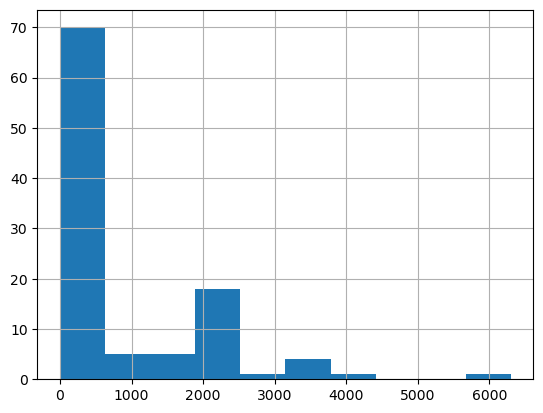

In [34]:
pd.Series(tokens_mscorsvw_wt[i_nonzero]).hist()

In [35]:
pd.Series(mscorsvw_vec.data).value_counts()

1.0    73510
2.0     4746
3.0     1386
4.0       66
5.0        7
6.0        1
Name: count, dtype: int64

In [36]:
imax = np.argmax(tokens_mscorsvw_wt)
imax

288

In [37]:
vz_bpe.tokens_[imax]

'14'

In [38]:
import pynndescent

In [44]:
# Say a point v is the center of a clump if there exist r, R satisfying (i) there are at least n_min points within distance r, (ii) there are no points at distance between r and R, and (iii) R-r > sep.

def grab_seperated_clumps(X, sep ,n_min,k_max):
    n = X.shape[0]
    used = [False]*n
    # Build KNN graph.
    nn_index = pynndescent.NNDescent(pd.DataFrame(X), metric="euclidean", n_neighbors=k_max+1, n_trees=8, max_candidates=20,parallel_batch_queries = True)
    nn_inds = nn_index.neighbor_graph[0]
    nn_dists = nn_index.neighbor_graph[0]

    clumps = []
    for i in range(n):
        if used[i] == False:
            clumpy, ind = is_clumpy(i,[x for x in nn_dists[i,:]],sep,n_min)
            if clumpy:
                temp = []
                for j in range(ind+1):
                    used[nn_inds[i,j]] = True
                    temp.append(nn_inds[i,j])
                clumps.append(temp)
    return clumps




In [45]:
def is_clumpy(i, dists,sep,n_min):
    for j in range(n_min,len(dists)-1):
        if dists[j+1] - dists[j] > sep:
            return True, j
    return False, None



In [42]:
cmdlines_iwt[mscorsvw.index]

<9349x574 sparse matrix of type '<class 'numpy.float64'>'
	with 79716 stored elements in Compressed Sparse Row format>

In [52]:
%%time
clumps = grab_seperated_clumps(cmdlines_iwt_dmap[mscorsvw.index], .2, 5, 150)

CPU times: user 54.3 s, sys: 10.4 s, total: 1min 4s
Wall time: 4.82 s


In [53]:
len(clumps)

2446

In [54]:
clumps[0]

[0, 6301, 1577, 1038, 511, 3075]

In [59]:
pd.set_option("display.max_colWidth", None)

In [60]:
mscorsvw_cmdlines.iloc[clumps[0]]

0                                                                                                     c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe
6301                                                                                                    c:\windows\microsoft.net\framework\v4.0.30319\mscorsvw.exe
1577    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 38c -interruptevent 0 -ngenprocess 5f8 -pipe 62c -comment "ngen worker process"
1038    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 30c -interruptevent 0 -ngenprocess 308 -pipe 1cc -comment "ngen worker process"
511     c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 24c -interruptevent 0 -ngenprocess 308 -pipe 56c -comment "ngen worker process"
3075    c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 52c -interruptevent 0 -ngenprocess 348 -pipe 30c -comment "ngen worker process"
dtype: object

In [61]:
mscorsvw_cmdlines.iloc[clumps[1]]

1       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1004 -interruptevent 0 -ngenprocess 100c -pipe c78 -comment "ngen worker process"
3589      c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 5c4 -interruptevent 0 -ngenprocess 4bc -pipe 1c8 -comment "ngen worker process"
6134      c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent d54 -interruptevent 0 -ngenprocess e9c -pipe de8 -comment "ngen worker process"
6298      c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent ff4 -interruptevent 0 -ngenprocess ffc -pipe ff8 -comment "ngen worker process"
6166      c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent dc4 -interruptevent 0 -ngenprocess e1c -pipe e08 -comment "ngen worker process"
2389      c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 454 -interruptevent 0 -ngenprocess 39c -pipe 778 -comment "ngen worker process"
1686      

In [62]:
mscorsvw_cmdlines.iloc[clumps[2]]

2       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1004 -interruptevent 0 -ngenprocess 1024 -pipe 100c -comment "ngen worker process"
3594       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 5c4 -interruptevent 0 -ngenprocess 544 -pipe 76c -comment "ngen worker process"
1771       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 3b4 -interruptevent 0 -ngenprocess 624 -pipe 59c -comment "ngen worker process"
274        c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 1f4 -interruptevent 0 -ngenprocess 664 -pipe 56c -comment "ngen worker process"
5131       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 7a4 -interruptevent 0 -ngenprocess 724 -pipe 21c -comment "ngen worker process"
5323       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 7f4 -interruptevent 0 -ngenprocess 334 -pipe 39c -comment "ngen worker process"
998 

In [63]:
mscorsvw_cmdlines.iloc[clumps[3]]

3       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 101c -interruptevent 0 -ngenprocess 100c -pipe 1018 -comment "ngen worker process"
4263       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 68c -interruptevent 0 -ngenprocess 67c -pipe 478 -comment "ngen worker process"
2826       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 4dc -interruptevent 0 -ngenprocess 44c -pipe 508 -comment "ngen worker process"
2123       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 40c -interruptevent 0 -ngenprocess 3dc -pipe 578 -comment "ngen worker process"
938        c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 2fc -interruptevent 0 -ngenprocess 1dc -pipe 1c8 -comment "ngen worker process"
2491       c:\windows\microsoft.net\framework64\v4.0.30319\mscorsvw.exe -startupevent 46c -interruptevent 0 -ngenprocess 4dc -pipe 4b8 -comment "ngen worker process"
945 

---

In [71]:
%%time
cmdlines_vec_dmap_alg, cmdlines_iwt_dmap_alg = procrustes_align(cmdlines_vec_dmap, cmdlines_iwt_dmap, scale_to='first')

CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 2.81 ms


In [26]:
hover_text = (
    metadata_interesting
    .iloc[i_unique]
    .assign(
        count_summary=pd.Series(cmdline_counts, index=metadata_interesting.iloc[i_unique].index).apply(lambda c: f"({c}x) " if c > 1 else ""),
        space=" "
    )[["count_summary", "process_name", "space", "args"]]
    .fillna("")
    .sum(axis=1)
    .apply(lambda cl: cl[:100] + "[...]" if len(cl) > 100 else cl)
    .tolist()
)
pd.Series(hover_text)

0                                               csrss.exe 
1        (126x) csrss.exe objectdirectory=\windows shar...
2        musnotificationux.exe /clearactivenotification...
3        musnotificationux.exe /clearactivenotification...
4        musnotificationux.exe /clearactivenotification...
                               ...                        
31041    (80x) bash.exe --norc -c "export path=/usr/bin...
31042    (18x) mintty.exe --nodaemon -o appid=gitforwin...
31043                               (6x) vboxheadless.exe 
31044    vswhere.exe -property catalog_productsemanticv...
31045                                    (50x) wlrmdr.exe 
Length: 31046, dtype: object

In [27]:
base_data_labels = metadata_interesting.iloc[i_unique]["process_name"].copy()
topk = base_data_labels.value_counts()[:30].index
base_data_labels.loc[~base_data_labels.isin(topk)] = 'Unlabelled'

In [28]:
%%time
base_data_map = cmdlines_vec_dmap_alg

unique_non_noise_labels = [
    label for label in np.unique(base_data_labels) if label != "Unlabelled"
]
cluster_centers = np.asarray([
    base_data_map[base_data_labels== label].mean(axis=0)
    for label in unique_non_noise_labels
])
palette = dmp.palette_handling.palette_from_datamap(
    base_data_map,
    cluster_centers,
    hue_shift=0.0,
    radius_weight_power=1.0,
    min_lightness=15,
)
label_color_map = dict(zip(unique_non_noise_labels, palette))

CPU times: user 91.4 ms, sys: 0 ns, total: 91.4 ms
Wall time: 90.7 ms


Build a static datamap with a fixed colour palette and get it's x and y limits for future plot consistency.

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment
CPU times: user 26.8 s, sys: 0 ns, total: 26.8 s
Wall time: 25 s


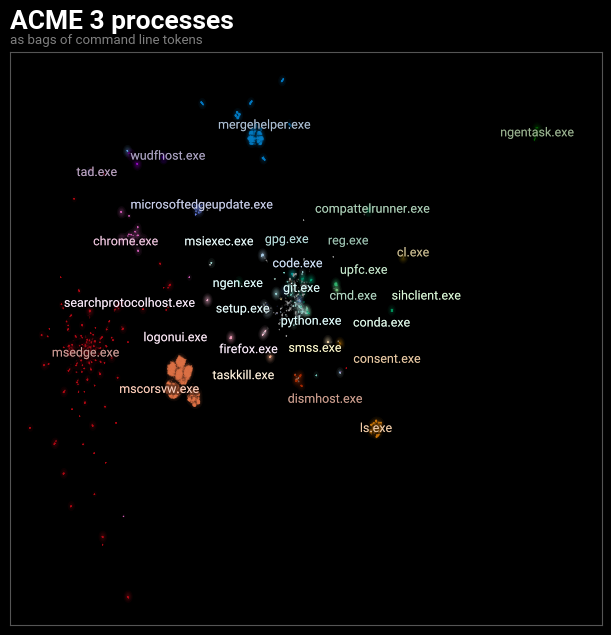

In [67]:
%%time
plot_vec, ax_vec = dmp.create_plot(
    cmdlines_vec_dmap_alg,
    base_data_labels,
    figsize=(6,6),
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as bags of command line tokens",
    #enable_search=True,
    label_font_size="9",
    use_medoids=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
xlim = ax_vec.get_xlim()
ylim = ax_vec.get_ylim()

# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment
CPU times: user 26.4 s, sys: 0 ns, total: 26.4 s
Wall time: 25.3 s


(-23.0742113424672, 19.237140122819063)

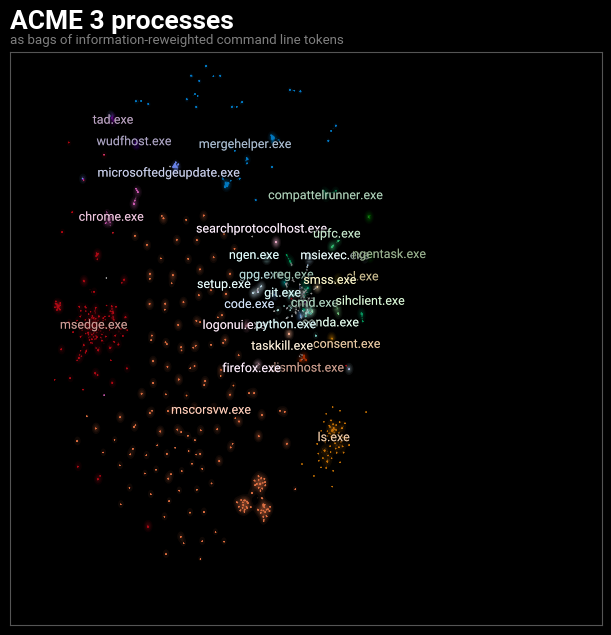

In [72]:
%%time
plot_iwt, ax_iwt = dmp.create_plot(
    cmdlines_iwt_dmap_alg,
    base_data_labels,
    figsize=(6,6),
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as bags of information-reweighted command line tokens",
    #enable_search=True,
    label_font_size="9",
    use_medoids=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
ax_iwt.set_xlim(xlim)
ax_iwt.set_ylim(ylim)

# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

In [30]:
%%time
plot_html = dmp.create_interactive_plot(
    cmdlines_iwt_dmap,
    metadata_u["process_name"],
    hover_text=[f"({x}, {y})" for x, y in cmdlines_iwt_dmap_alg],
    # font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as bags of information-reweighted command line tokens",
    #enable_search=True,
    # use_medoids=True,
    darkmode=True,
    # label_color_map=label_color_map,
)
# plot_html.save("iwt.html")
plot_html
# ax_iwt.set_xlim(xlim)
# ax_iwt.set_ylim(ylim)

# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

CPU times: user 485 ms, sys: 0 ns, total: 485 ms
Wall time: 587 ms


<InteractiveFigure width=100% height=800>

In [22]:
cmdlines_bpe = jl.Parallel(n_jobs=os.cpu_count())(
    jl.delayed(eng.bpe.bpe_encode)(cmdline, code_list, max_char_code=127)
    for cmdline in tqdm(cmdlines.iloc[i_unique])
)
pd.Series(cmdlines_bpe)

  0%|          | 0/31046 [00:00<?, ?it/s]

0        [37, 412, 131, 111, 116, 37, 92, 466, 99, 115,...
1        [37, 412, 131, 111, 116, 37, 92, 466, 99, 115,...
2        [37, 412, 131, 111, 116, 37, 92, 452, 136, 294...
3        [37, 412, 131, 111, 116, 37, 92, 452, 136, 294...
4        [37, 412, 131, 111, 116, 37, 92, 452, 136, 294...
                               ...                        
31041    [294, 114, 532, 134, 532, 97, 537, 320, 110, 1...
31042    [294, 114, 532, 134, 136, 240, 153, 320, 609, ...
31043        [118, 428, 104, 101, 409, 137, 115, 115, 149]
31044    [118, 115, 119, 104, 129, 101, 207, 138, 391, ...
31045                  [119, 108, 114, 109, 100, 114, 149]
Length: 31046, dtype: object

In [636]:
%%time
cmdlines_bpe = vz.BytePairEncodingVectorizer(
    max_vocab_size=600,
    return_type="sequences"
).fit_transform(cmdlines_u.tolist())
vz_cooc = vz.TokenCooccurrenceVectorizer(
    n_threads=os.cpu_count(),
    n_iter=3
).fit(cmdlines_bpe)
cooc_vec = vz_cooc.reduce_dimension(128)
cooc_vec.shape

CPU times: user 1min 28s, sys: 1.83 s, total: 1min 30s
Wall time: 12 s


(574, 128)

In [53]:
%%time
tokens_cooc_dmap = umap.UMAP(metric="cosine", verbose=True).fit_transform(tokens_cooc)

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Tue Jul  2 21:23:57 2024 Construct fuzzy simplicial set
Tue Jul  2 21:23:58 2024 Finding Nearest Neighbors
Tue Jul  2 21:23:58 2024 Finished Nearest Neighbor Search
Tue Jul  2 21:23:58 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul  2 21:24:00 2024 Finished embedding
CPU times: user 19.8 s, sys: 978 ms, total: 20.8 s
Wall time: 2.92 s


CPU times: user 171 ms, sys: 3.09 ms, total: 174 ms
Wall time: 1.11 s


(<Figure size 600x600 with 1 Axes>, <Axes: >)

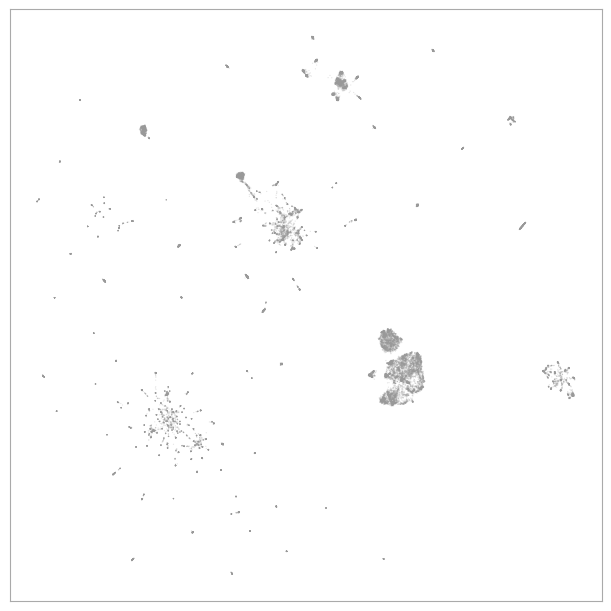

In [72]:
%%time
dmp.create_plot(
    cmdlines_hg_dmap,
    # base_data_labels,
    figsize=(6,6),
    #hover_text=hover_text,
    font_family="Roboto",
    # title="ACME 3 command line tokens",
    #enable_search=True,
    # label_font_size="9",
    # use_medoids=True,
    # darkmode=True,
    # label_over_points=True,
    # label_color_map=label_color_map,
)
# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

In [622]:
%%time
coo_distrib = np.array([
    [row, vz_cooc.token_label_dictionary_[token], count]
    for row, cc in enumerate(tqdm(cmdlines_bpe))
    for token, count in zip(*np.unique(cc, return_counts=True))
])
cooc_distrib = sp.coo_matrix((coo_distrib[:, 2], (coo_distrib[:, 0], coo_distrib[:, 1])))
cooc_distrib

  0%|          | 0/31046 [00:00<?, ?it/s]

CPU times: user 2.58 s, sys: 187 ms, total: 2.77 s
Wall time: 2.76 s


<31046x575 sparse matrix of type '<class 'numpy.int64'>'
	with 822128 stored elements in COOrdinate format>

In [88]:
%%time
cmdlines_hg = vz.WassersteinVectorizer().fit_transform(cooc_distrib, vectors=cooc_vec)
cmdlines_hg.shape

CPU times: user 10min 36s, sys: 2min 18s, total: 12min 55s
Wall time: 25.3 s


(31046, 128)

In [34]:
%%time
cmdlines_hg_dmap = umap.UMAP(n_neighbors=50, init=cmdlines_vec_dmap, metric="cosine", n_epochs=500, verbose=True).fit_transform(cmdlines_hg)

UMAP(angular_rp_forest=True, init=array([[14.370911, 12.046755],
       [ 7.590741, 11.432909],
       [ 8.354164, 8.445178],
       ...,
       [ 7.394114, 9.734524],
       [10.825596, 13.920356],
       [ 8.152493, 10.051785]], dtype=float32), metric='cosine', n_epochs=500, n_neighbors=50, verbose=True)
Tue Jul  2 21:05:01 2024 Construct fuzzy simplicial set
Tue Jul  2 21:05:01 2024 Finding Nearest Neighbors
Tue Jul  2 21:05:01 2024 Building RP forest with 14 trees
Tue Jul  2 21:05:01 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Jul  2 21:05:06 2024 Finished Nearest Neighbor Search
Tue Jul  2 21:05:07 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul  2 21:05:45 2024 Finished embedding
CPU times: user 20min 43s, sys: 6.55 s, total: 20min 50s
Wall time: 43.7 s


In [35]:
%%time
cmdlines_vec_dmap_alg2, cmdlines_hg_dmap_alg = procrustes_align(cmdlines_vec_dmap, cmdlines_hg_dmap, scale_to='both')

CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 2.14 ms


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment
CPU times: user 29.6 s, sys: 78.9 ms, total: 29.7 s
Wall time: 28.7 s


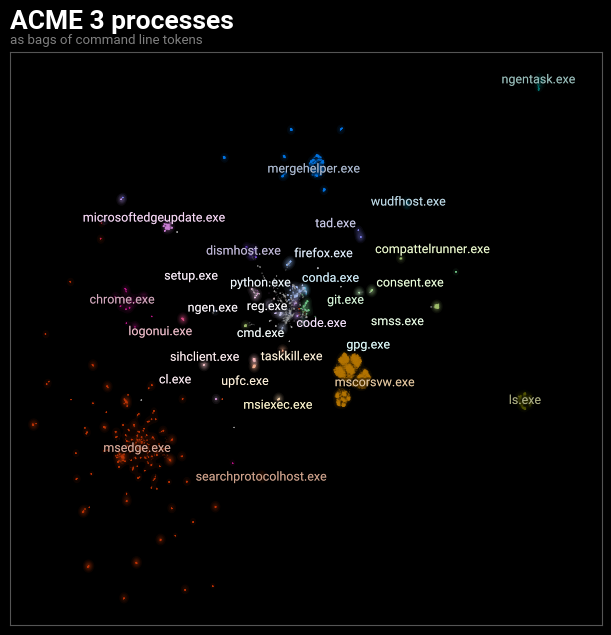

In [36]:
%%time
plot_vec2, ax_vec2 = dmp.create_plot(
    cmdlines_vec_dmap_alg2,
    base_data_labels,
    figsize=(6,6),
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as bags of command line tokens",
    #enable_search=True,
    label_font_size="9",
    use_medoids=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
xlim = ax_vec2.get_xlim()
ylim = ax_vec2.get_ylim()

# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment
CPU times: user 37.5 s, sys: 2.82 s, total: 40.4 s
Wall time: 39.2 s


(-22.161119307123602, 21.629810504615307)

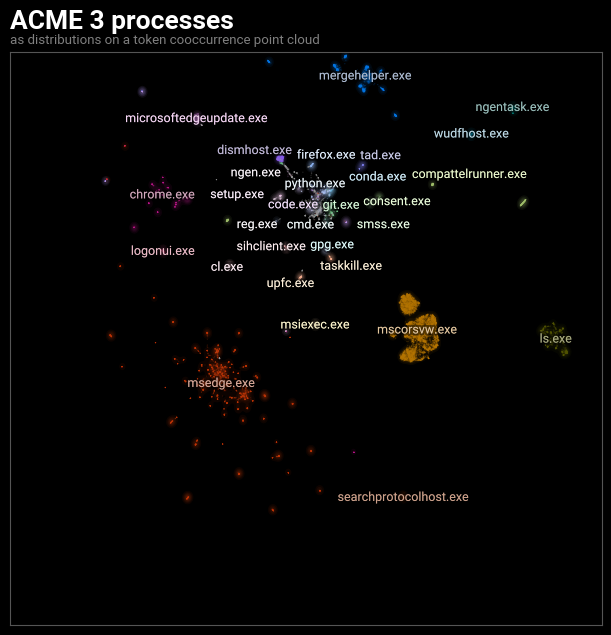

In [37]:
%%time
plot_hg, ax_hg = dmp.create_plot(
    cmdlines_hg_dmap,
    base_data_labels,
    figsize=(6,6),
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as distributions on a token cooccurrence point cloud",
    #enable_search=True,
    label_font_size="9",
    use_medoids=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
ax_hg.set_xlim(xlim)
ax_hg.set_ylim(ylim)

# plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

In [ ]:
plot_hg = dmp.create_interactive_plot(
    datamap_hg,
    metadata_interesting.iloc[i_unique]["process_name"],
    hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of cooccurrence vectors of command line tokens",
    enable_search=True,
    darkmode=True,
)
plot_hg

Build a similar plot for a the wasserstein embedding with the same x and y limits.

## Now let's try fasttext

TODO: I need to use the BPE tokenizer here instead of the white space one.

---

In [96]:
%%dql
select hostname, count(distinct pid_hash)
from process
group by hostname

,hostname,count(DISTINCT pid_hash)
0,ACME-HH-BVW,169113
1,ACME-HH-MBY,151184
2,ACME-HH-AKA,133594
3,ACME-WS-UVF,100107
4,ACME-HH-OLY,137213
5,ACME-HH-EAY,154881
6,ACME-HH-AZH,177341
7,ACME-HH-CLR,67486
8,ACME-HH-DFN,148883
9,ACME-HH-UWI,143733


In [97]:
procs = db.execute(
    """
    select hostname, day, count(distinct pid_hash) as num
    from (
        select pid_hash, hostname, cast(datetrunc('day', process_started) as date) as day
        from process_interesting
        where process_started = first_seen
    )
    group by hostname, day
    order by hostname, day
    """
).df()
procs_nona = procs.dropna(subset=["day"])
procs_per_hostday = procs_nona.loc[procs_nona["day"] >= pd.Timestamp("2023-11-05")].set_index(["hostname", "day"]).unstack("day").fillna(0)
procs_per_hostday

num                                                         \
day         2023-11-05 2023-11-06 2023-11-07 2023-11-08 2023-11-09 2023-11-10   
hostname                                                                        
ACME-DC1         337.0      392.0      263.0     3346.0      584.0      384.0   
ACME-HH-AKA      814.0      815.0      576.0      409.0      345.0      714.0   
ACME-HH-ATV        0.0     1636.0      537.0      237.0      384.0      253.0   
ACME-HH-AXF      198.0      652.0      302.0      270.0      266.0      250.0   
ACME-HH-AZH      251.0      836.0      353.0      287.0      287.0      256.0   
ACME-HH-BVW        0.0        0.0      115.0       18.0       27.0        9.0   
ACME-HH-CCF      268.0      925.0     1107.0      430.0      315.0      270.0   
ACME-HH-CLR      197.0     2724.0     1717.0     1112.0      686.0     1097.0   
ACME-HH-DFN      198.0      193.0      428.0      271.0      263.0      281.0   
ACME-HH-EAY      254.0      998.0     3099.0     1326.0     1028.0      751.0   
ACME-HH-HGC      193.0      480.0      232.0      308.0      370.0      288.0   
ACME-HH-IKA        0.0      344.0     4454.0      920.0      251.0      258.0   
ACME-HH-IQS      242.0      713.0      418.0      300.0      316.0      368.0   
ACME-HH-KKN        0.0      347.0      228.0      454.0      428.0      447.0   
ACME-HH-MBY      189.0      478.0      229.0     1299.0     1178.0      427.0   
ACME-HH-OLY      194.0      195.0      193.0      201.0      200.0      196.0   
ACME-HH-TON        0.0       23.0        0.0        0.0        0.0        0.0   
ACME-HH-TTW      194.0      187.0      195.0      203.0      191.0      207.0   
ACME-HH-UWI      190.0      479.0      223.0      205.0      205.0      302.0   
ACME-HH-YIM      185.0      193.0      190.0      201.0      202.0      213.0   
ACME-WS-AZU      220.0      232.0      224.0      217.0      251.0      239.0   
ACME-WS-NUQ      199.0      390.0      484.0      380.0     2865.0      601.0   
ACME-WS-PLU      329.0      427.0      505.0      387.0     8778.0      383.0   
ACME-WS-PRV      203.0      424.0      233.0      212.0      234.0     3348.0   
ACME-WS-UVF      216.0      226.0      234.0      233.0      229.0      234.0   

                                                                               \
day         2023-11-11 2023-11-12 2023-11-13 2023-11-14 2023-11-15 2023-11-16   
hostname                                                                        
ACME-DC1         267.0      283.0      312.0      447.0      301.0      298.0   
ACME-HH-AKA      381.0      274.0     1104.0     1354.0      314.0      612.0   
ACME-HH-ATV      268.0      267.0      414.0      344.0      282.0      275.0   
ACME-HH-AXF      284.0      259.0      262.0      245.0      269.0      255.0   
ACME-HH-AZH      289.0      261.0      861.0      285.0      380.0      310.0   
ACME-HH-BVW       12.0       11.0       11.0       16.0       16.0     3578.0   
ACME-HH-CCF      288.0      277.0      293.0      306.0      321.0      311.0   
ACME-HH-CLR        0.0        0.0        0.0        0.0        0.0        0.0   
ACME-HH-DFN      252.0      248.0      255.0      264.0      277.0      277.0   
ACME-HH-EAY      196.0      193.0      193.0      213.0      195.0     1148.0   
ACME-HH-HGC      227.0      213.0      223.0      215.0      227.0      218.0   
ACME-HH-IKA      259.0      238.0      298.0      574.0      273.0      256.0   
ACME-HH-IQS      291.0      281.0      280.0      296.0      310.0      321.0   
ACME-HH-KKN      444.0      436.0      440.0      439.0      435.0      432.0   
ACME-HH-MBY      339.0      284.0      334.0      301.0      321.0      323.0   
ACME-HH-OLY      202.0      194.0      188.0      203.0      192.0      188.0   
ACME-HH-TON        0.0        0.0        0.0        0.0        0.0        0.0   
ACME-HH-TTW      190.0      203.0      186.0      202.0      192.0      198.0   
ACME-HH-UWI      214.0      218.0      214.0     

<Axes: xlabel='None,day'>

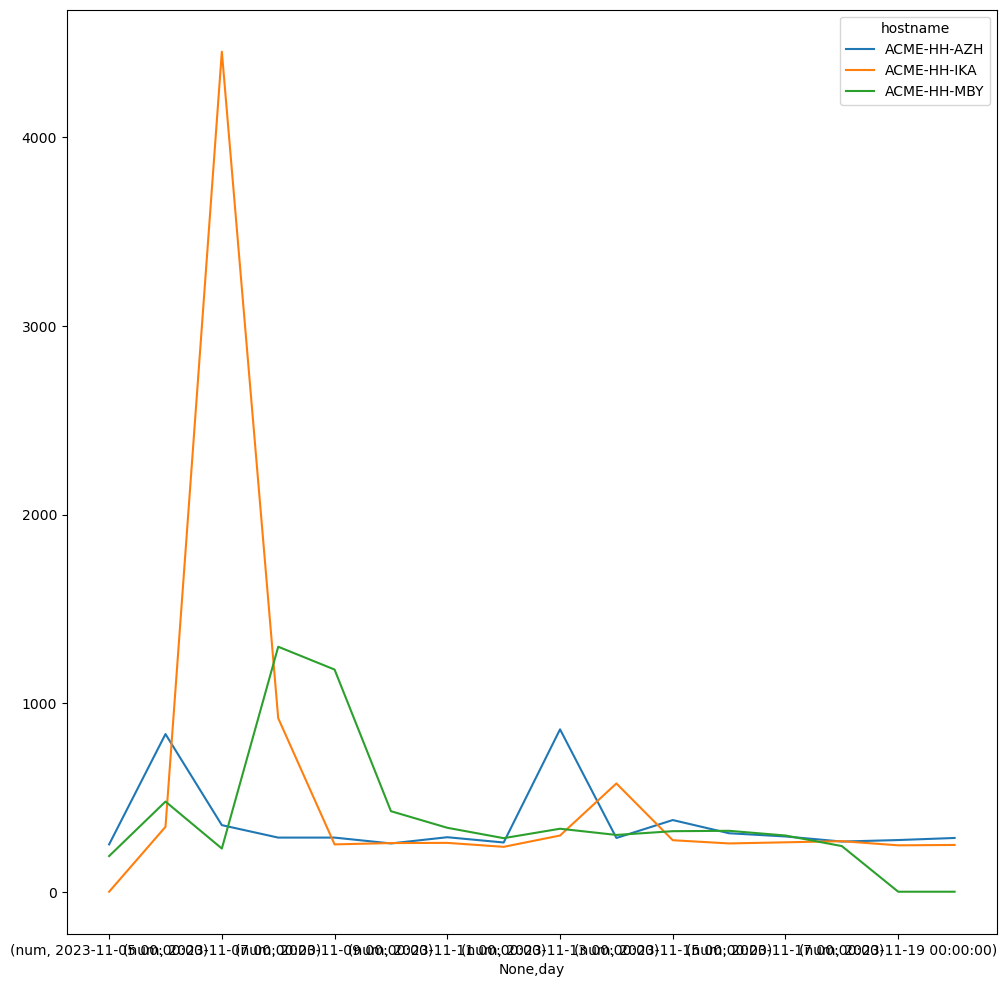

In [345]:
plt.figure(figsize=(12, 12))
procs_per_hostday.loc[["ACME-HH-AZH", "ACME-HH-IKA", "ACME-HH-MBY"]].T.plot(ax=plt.gca())

---

In [38]:
%%dql
describe process_image_load

,column_name,column_type,null,key,default,extra
0,pid_hash,VARCHAR,YES,None,None,None
1,filename,VARCHAR,YES,None,None,None
2,agent_id,VARCHAR,YES,None,None,None
3,hostname,VARCHAR,YES,None,None,None
4,process_name,VARCHAR,YES,None,None,None
5,file_id,VARCHAR,YES,None,None,None
6,file_md5,VARCHAR,YES,None,None,None
7,build_time,BIGINT,YES,None,None,None
8,checksum,INTEGER,YES,None,None,None
9,default_base,VARCHAR,YES,None,None,None


In [39]:
%%dql
create or replace view image_load as
select pid_hash, process_image_load.hostname, process_image_load.first_seen as timestamp, process_interesting.process_name, process_image_load.filename
from process_image_load
inner join process_interesting using (pid_hash)

,Count


In [40]:
%%dql -o process_x_image
select pid_hash, process_name, array_agg(filename) as images, array_agg(timestamp) as timestamps
from image_load
group by pid_hash, process_name

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,pid_hash,process_name,images,timestamps
0,CDD6119D7A696D1F13937798E3400C82,msedge.exe,"[c:\windows\system32\rpcrt4.dll, c:\windows\sy...","[2023-11-06T18:44:03.499467, 2023-11-06T18:44:..."
1,74088FA3805E34EFF1713A366E47F689,dismhost.exe,[c:\users\grantj\appdata\local\temp\8d5f1933-8...,"[2023-11-06T15:10:46.805582, 2023-11-06T15:10:..."
2,94A66BE8ED883F5FDB32D6CB9E4A49EE,compattelrunner.exe,"[c:\windows\system32\drvstore.dll, c:\windows\...","[2023-11-07T14:15:50.244220, 2023-11-07T14:15:..."
3,8713EF569C5550B34AE854CB0BD411C2,mousocoreworker.exe,"[c:\windows\system32\bcryptprimitives.dll, c:\...","[2023-11-07T20:46:16.380369, 2023-11-07T20:46:..."
4,D6D7FA113B65E8EF877BA716492CE684,mscorsvw.exe,"[c:\windows\system32\profapi.dll, c:\windows\s...","[2023-11-07T17:24:21.339994, 2023-11-07T17:24:..."
...,...,...,...,...
41341,57721D46306217623B3016D38198364E,wmiprvse.exe,[c:\windows\system32\wbem\wbemprox.dll],[2023-11-13T23:59:35.263668]
41342,DAA36C41DD9A5489944641BBE9C81D99,python.exe,[c:\windows\system32\textshaping.dll],[2023-11-13T20:56:21.952007]
41343,12456E2271AF75779DC6D472BCDC89F4,tiworker.exe,[c:\windows\system32\slc.dll],[2023-11-15T12:26:19.462223]
41344,A476DD7A6C32AFF8BE05E0811131E6EE,gc_service.exe,[c:\windows\system32\ondemandconnroutehelper.dll],[2023-11-08T23:08:49.591201]


In [41]:
%%time
vz_ngram = vz.NgramVectorizer().fit(process_x_image["images"])
vz_ngram

CPU times: user 6.33 s, sys: 543 ms, total: 6.87 s
Wall time: 6.87 s


NgramVectorizer()

In [42]:
procdlls_vec = vz_ngram._train_matrix
procdlls_vec

<41346x8322 sparse matrix of type '<class 'numpy.float32'>'
	with 1621851 stored elements in Compressed Sparse Row format>

In [43]:
%%time
sum_rows = np.array(np.sum(procdlls_vec, axis=0)).squeeze()
dll_cooc = sp.diags(sum_rows) @ procdlls_vec.T @ procdlls_vec
dll_cooc

CPU times: user 265 ms, sys: 3.51 ms, total: 268 ms
Wall time: 268 ms


<8322x8322 sparse matrix of type '<class 'numpy.float32'>'
	with 2986758 stored elements in Compressed Sparse Row format>

In [45]:
%%time
dll_svd = TruncatedSVD(n_components=128).fit_transform(dll_cooc)
dll_svd.shape

CPU times: user 15.5 s, sys: 3.12 s, total: 18.6 s
Wall time: 1.68 s


(8322, 128)

In [46]:
%%time
coo_distrib = np.array([
    (row, vz_ngram.column_label_dictionary_[token], count)
    for row, images in enumerate(process_x_image["images"])
    for token, count in zip(*np.unique(images, return_counts=True))
])
distrib = sp.coo_matrix((coo_distrib[:, 2], (coo_distrib[:, 0], coo_distrib[:, 1])))
distrib

CPU times: user 1.41 s, sys: 218 ms, total: 1.63 s
Wall time: 1.62 s


<41346x8322 sparse matrix of type '<class 'numpy.int64'>'
	with 1621851 stored elements in COOrdinate format>

In [47]:
%%time
procdlls_hg = vz.WassersteinVectorizer().fit_transform(distrib, vectors=dll_svd)
procdlls_hg.shape

CPU times: user 45min 3s, sys: 9min 24s, total: 54min 28s
Wall time: 1min 38s


(41346, 128)

In [48]:
%%time
procdlls_hg_map = umap.UMAP(metric="cosine", verbose=True).fit_transform(procdlls_hg)

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Tue Jul  2 21:12:12 2024 Construct fuzzy simplicial set
Tue Jul  2 21:12:12 2024 Finding Nearest Neighbors
Tue Jul  2 21:12:12 2024 Building RP forest with 15 trees
Tue Jul  2 21:12:12 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Tue Jul  2 21:12:14 2024 Finished Nearest Neighbor Search
Tue Jul  2 21:12:14 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jul  2 21:12:54 2024 Finished embedding
CPU times: user 20min 39s, sys: 27.6 s, total: 21min 6s
Wall time: 41.7 s


In [49]:
procdlls_labels = process_x_image["process_name"].copy()
topk = procdlls_labels.value_counts()[:30].index
procdlls_labels.loc[~procdlls_labels.isin(topk)] = 'Unlabelled'
procdlls_labels

0                 msedge.exe
1                 Unlabelled
2        compattelrunner.exe
3        mousocoreworker.exe
4               mscorsvw.exe
                ...         
41341           wmiprvse.exe
41342             python.exe
41343           tiworker.exe
41344             Unlabelled
41345            svchost.exe
Name: process_name, Length: 41346, dtype: object

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment
CPU times: user 1min 10s, sys: 5.28 s, total: 1min 16s
Wall time: 1min 14s


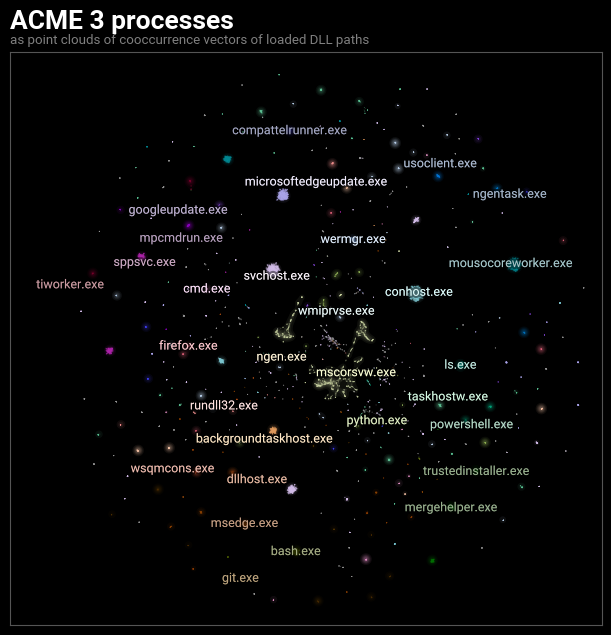

In [52]:
%%time
plot_procdlls_hg, _ = dmp.create_plot(
    procdlls_hg_map,
    procdlls_labels,
    #hover_text=hover_text,
    figsize=(6,6),
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="as point clouds of cooccurrence vectors of loaded DLL paths",
    #enable_search=True,
    use_medoids=True,
    label_font_size="9",
    darkmode=True,
    label_over_points=True,
    # label_color_map=label_color_map,
)
# ax.set_xlim = xlim
# ax.set_ylim = ylim
# plot_procdlls_hg.savefig('acme3_wass_datamap_dlls.png', bbox_inches="tight")

---

In [107]:
%%time
metadata_indexed = metadata_interesting.assign(index_vec=dict(enumerate(i_deunique)))
metadata_indexed

CPU times: user 229 ms, sys: 32.2 ms, total: 262 ms
Wall time: 261 ms


,pid_hash,parent_pid_hash,process_name,process_path,args,ptree,hostname,timestamp,index_vec
0,0000283F736E630ABFCC5AA836DA8DE6,6DB651F1EAD84F88801332945F69A5F2,rundll32.exe,c:\windows\system32\rundll32.exe,c:\windows\system32\windows.staterepositorycli...,=rundll32.exe->svchost.exe->services.exe->wini...,ACME-HH-TTW,2023-11-08 14:15:49.683641+00:00,28925
1,000057E3B323CF730E68A978E00E8E53,C991863B4324678B5FF92D1A04E11CF4,mergehelper.exe,c:\program files\wintap\mergertool\mergehelper...,c:\programdata\wintap\parquet\default_sensor\m...,=mergehelper.exe->smss.exe->smss.exe->ntoskrnl...,ACME-WS-PLU,2023-11-09 11:47:37.440153+00:00,11920
2,0000ED740D89D0FD67FEDD3A460D1233,E1BB141B4D041B0485BCA35B4A52725F,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 224 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...,ACME-WS-NUQ,2023-11-09 20:09:39.039176+00:00,17094
3,00011F5A487D54C57AD3D7B5CF49B8D6,853E6A28F9CDE865C4D761475F2FE6DB,dsregcmd.exe,c:\windows\system32\dsregcmd.exe,$(arg0) $(arg1) $(arg2),=dsregcmd.exe->svchost.exe->services.exe->wini...,ACME-HH-AKA,2023-11-17 06:52:59.176362+00:00,28343
4,0001A7D9420F65F0E8B07E78E1D26B45,5319246012A53BB36BAC5DBDA231D7B0,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...,ACME-HH-HGC,2023-11-17 18:27:54.370126+00:00,6973
...,...,...,...,...,...,...,...,...,...
137842,FFFD4487BC268AEDAF4460E91D9EA109,4513F1678CB5D6E0E95F95DA0ECB2E2D,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...,ACME-WS-PRV,2023-11-05 09:20:00.219223+00:00,6973
137843,FFFE1903C27DA29570F2E06FF02ECD95,269548B3623B541DD38D6B73AFAC2244,msedge.exe,c:\program files (x86)\microsoft\edge\applicat...,--type=renderer --disable-nacl --disable-gpu-c...,=msedge.exe->na.exe->ntoskrnl.exe,ACME-DC1,2023-11-05 21:21:20.362937+00:00,545
137844,FFFE89C9D856A2CA183895879FD210E0,CC4EFBD4A491E06FB568D3BE2A7F3DA8,svchost.exe,c:\windows\system32\svchost.exe,-k netsvcs -p -s netsetupsvc,=svchost.exe->services.exe->wininit.exe->smss....,ACME-HH-DFN,2023-11-16 21:01:01.242689+00:00,29492
137845,FFFF1E20E3041AA26D33FB1C563C1AEF,381DD681D08B21CAA47EF823BB3AA8D1,python.exe,c:\users\user6\desktop\extend_bincfg\.venv\scr...,"""c:\users\user6\desktop\extend_bincfg\.venv\sc...",=python.exe->pip.exe->powershell.exe->code.exe...,ACME-HH-CCF,2023-11-07 17:30:42.087120+00:00,16406


In [108]:
metadata_unique = metadata_indexed.iloc[i_unique].set_index("index_vec")
metadata_unique

,pid_hash,parent_pid_hash,process_name,process_path,args,ptree,hostname,timestamp
index_vec,,,,,,,,
0,45EBAFA4120EBD83795F91B021C2C987,AAF97101D35382DDB72DCD4FEE05818C,csrss.exe,%systemroot%\system32\csrss.exe,None,=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe,ACME-HH-AKA,2023-11-14 00:22:19.554954+00:00
1,03A4AD4CE884C4D2CB9CE23607E4A35E,335D6A59E07FC78DE64768014933B6CB,csrss.exe,%systemroot%\system32\csrss.exe,"objectdirectory=\windows sharedsection=1024,20...",=csrss.exe->smss.exe->smss.exe->ntoskrnl.exe,ACME-HH-ATV,2023-11-08 16:01:37.414747+00:00
2,71A014969332AF0C1E0FBFC883BEB8FF,8A11985B996D25FAA8FC6F94A809E609,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4mihmtqkbeq8ipb4.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-IQS,2023-11-07 19:42:03.258287+00:00
3,83FB4E68D3AC8DA9B36A19FF158F9410,EB9FBBB61091C81393AE20E790E727E0,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4tajqs4wkk6kfb/j.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-AZH,2023-11-14 04:48:15.658330+00:00
4,A5F0F3DB7F64C157C48A7CCBFDCCB9DD,B2DD3FB8C188BC146EECC8FDACD9AAAB,musnotificationux.exe,%systemroot%\system32\musnotificationux.exe,/clearactivenotifications /cv 4uqlwvfixukjkqzh.0,=musnotificationux.exe->musnotification.exe->s...,ACME-HH-AKA,2023-11-14 16:36:33.696670+00:00
...,...,...,...,...,...,...,...,...
31041,02DB21D8ABE8F5A2469091D66C6862FD,2B69DF1A23610FC8D0E5F50A03883E05,bash.exe,usr\bin\bash.exe,"--norc -c ""export path=/usr/bin:$path; export ...",=bash.exe->bash.exe->cmd.exe->git-2.42.0.2-64-...,ACME-HH-CLR,2023-11-06 18:06:39.448223+00:00
31042,14D7595BC2FB5628AAB10551544BB9ED,37E1609DD5A275CD904E84C2857EC4F9,mintty.exe,usr\bin\mintty.exe,--nodaemon -o appid=gitforwindows.bash -o appl...,=mintty.exe->git-bash.exe->explorer.exe->useri...,ACME-HH-EAY,2023-11-08 21:41:57.108226+00:00
31043,0F614EC33E232A39E9363BC8E8B5717D,A2EEEEB8800FD1E7DA1C4593BB0C00AE,vboxheadless.exe,vboxheadless.exe,None,=vboxheadless.exe->vboxheadless.exe->vboxsvc.e...,ACME-HH-CCF,2023-11-07 16:57:03.203161+00:00


In [109]:
%%time
processes_x_host_time = (
    metadata_indexed
    .groupby("hostname")
    .resample(pd.Timedelta(hours=3), on="timestamp", origin=pd.Timestamp('2023-11-05', tz="UTC"))
    .agg({"index_vec": lambda x: list(pd.Series(x).value_counts().items())})
    .dropna()
    .sort_index()
    .reset_index()
)
processes_x_host_time

CPU times: user 640 ms, sys: 0 ns, total: 640 ms
Wall time: 640 ms


,hostname,timestamp,index_vec
0,ACME-DC1,2023-11-05 00:00:00+00:00,"[(28653, 3), (6973, 3), (29492, 3), (29474, 2)..."
1,ACME-DC1,2023-11-05 03:00:00+00:00,"[(28653, 4), (6973, 3), (29492, 3), (29506, 2)..."
2,ACME-DC1,2023-11-05 06:00:00+00:00,"[(28653, 3), (29492, 3), (6973, 3), (29459, 3)..."
3,ACME-DC1,2023-11-05 09:00:00+00:00,"[(28653, 3), (29506, 3), (6973, 3), (29492, 3)..."
4,ACME-DC1,2023-11-05 12:00:00+00:00,"[(28129, 6), (28653, 4), (29515, 4), (6973, 3)..."
...,...,...,...
2621,ACME-WS-UVF,2023-11-18 03:00:00+00:00,"[(28653, 3), (29515, 3), (29459, 3), (29492, 3..."
2622,ACME-WS-UVF,2023-11-18 06:00:00+00:00,"[(28653, 4), (29492, 3), (6973, 3), (29515, 2)..."
2623,ACME-WS-UVF,2023-11-18 09:00:00+00:00,"[(28653, 3), (29492, 3), (6973, 3), (29515, 2)..."
2624,ACME-WS-UVF,2023-11-18 12:00:00+00:00,"[(28129, 9), (29515, 6), (6973, 3), (29459, 3)..."


In [110]:
_coo = processes_x_host_time.explode("index_vec").dropna()
coo_distribs_host_time = np.hstack(
    [
        np.reshape(_coo.index.to_numpy(), (-1, 1)),
        _coo["index_vec"].to_list()
    ]
)
coo_distribs_host_time.shape

(74778, 3)

In [111]:
%%time
distribs_host_time = sp.coo_matrix((
    coo_distribs_host_time[:, 2],
    (coo_distribs_host_time[:, 0], coo_distribs_host_time[:, 1])
))
distribs_host_time

CPU times: user 2.42 ms, sys: 0 ns, total: 2.42 ms
Wall time: 1.83 ms


<2626x31046 sparse matrix of type '<class 'numpy.int64'>'
	with 74778 stored elements in COOrdinate format>

In [112]:
%%time
distribs_host_time_iwt = vzt.InformationWeightTransformer().fit_transform(distribs_host_time).tocoo()
distribs_host_time_iwt

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 17.9 ms


<2626x31046 sparse matrix of type '<class 'numpy.float64'>'
	with 74778 stored elements in COOrdinate format>

In [113]:
distribs_host_time_coembed = sp.coo_matrix(
    (
        np.hstack([distribs_host_time_iwt.data, np.ones(distribs_host_time_iwt.shape[1])]),
        (
            np.hstack([distribs_host_time_iwt.row, distribs_host_time_iwt.shape[0] + np.arange(distribs_host_time_iwt.shape[1])]),
            np.hstack([distribs_host_time_iwt.col, np.arange(distribs_host_time_iwt.shape[1])])
        )
    )
)
distribs_host_time_coembed

<33672x31046 sparse matrix of type '<class 'numpy.float64'>'
	with 105824 stored elements in COOrdinate format>

In [114]:
%%time
host_time_vecs_all = vz.WassersteinVectorizer().fit_transform(distribs_host_time_coembed, vectors=cmdlines_hg)
host_time_vecs_all.shape

CPU times: user 2min 48s, sys: 14.8 s, total: 3min 3s
Wall time: 6.61 s


(33672, 128)

In [116]:
%%time
host_time_vecs = host_time_vecs_all[:distribs_host_time_iwt.shape[0], :]
host_time_processes = host_time_vecs_all[distribs_host_time_iwt.shape[0]:, :]
host_time_vecs.shape, host_time_processes.shape

CPU times: user 62 μs, sys: 0 ns, total: 62 μs
Wall time: 84.9 μs


((2626, 128), (31046, 128))

In [117]:
%%time
host_time_datamap = umap.UMAP(metric="cosine", verbose=True).fit_transform(host_time_vecs)

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Wed Jul  3 13:15:05 2024 Construct fuzzy simplicial set
Wed Jul  3 13:15:08 2024 Finding Nearest Neighbors
Wed Jul  3 13:15:08 2024 Finished Nearest Neighbor Search
Wed Jul  3 13:15:08 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Jul  3 13:15:13 2024 Finished embedding
CPU times: user 1min 49s, sys: 770 ms, total: 1min 50s
Wall time: 8.2 s


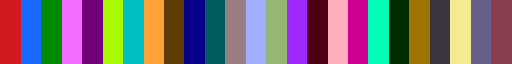

In [259]:
palette_hosts = gb.create_palette(processes_x_host_time["hostname"].nunique())#, colorblind_safe=True)
ListedColormap(palette_hosts)

CPU times: user 57.4 s, sys: 4.35 s, total: 1min 1s
Wall time: 1min 5s


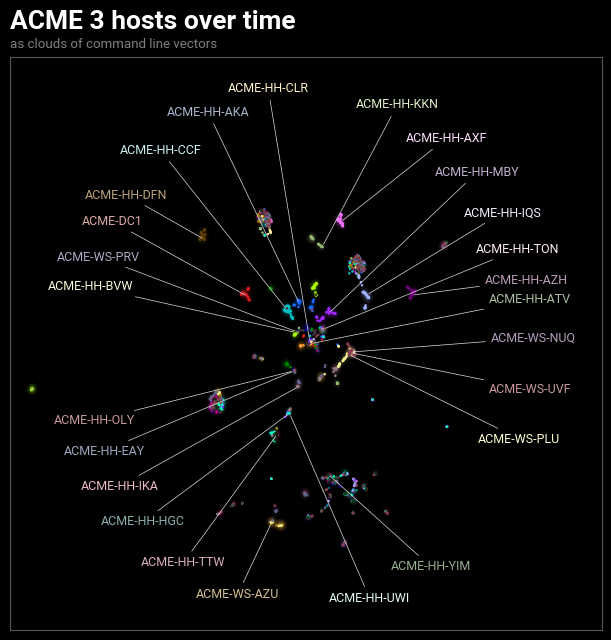

In [260]:
%%time
plot_host_time, _ = dmp.create_plot(
    host_time_datamap,
    processes_x_host_time["hostname"],
    #hover_text=hover_text,
    figsize=(6,6),
    font_family="Roboto",
    title="ACME 3 hosts over time",
    sub_title="as clouds of command line vectors",
    #enable_search=True,
    use_medoids=True,
    label_font_size="9",
    darkmode=True,
    # label_over_points=True,
    label_color_map=dict(zip(processes_x_host_time["hostname"].unique(), palette_hosts)),
)
# ax.set_xlim = xlim
# ax.set_ylim = ylim
plot_host_time.savefig('acme3_host_time.png', bbox_inches="tight")

# START HERE

In [261]:
import fast_hdbscan
import glasbey
from IPython.display import HTML
import matplotlib.animation
import scipy.signal
import datamapplot

import sklearn
import pylabeladjust
from matplotlib import patheffects

In [393]:
selected = processes_x_host_time.loc[processes_x_host_time["hostname"].isin({"ACME-HH-IQS", "ACME-HH-AZH", "ACME-HH-MBY"})]
selected

,hostname,timestamp,index_vec
449,ACME-HH-AZH,2023-11-05 00:00:00+00:00,"[(6973, 4), (29515, 3), (29492, 3), (29459, 3)..."
450,ACME-HH-AZH,2023-11-05 03:00:00+00:00,"[(28653, 4), (29492, 3), (6973, 3), (29506, 3)..."
451,ACME-HH-AZH,2023-11-05 06:00:00+00:00,"[(29492, 3), (6973, 3), (29506, 3), (28653, 3)..."
452,ACME-HH-AZH,2023-11-05 09:00:00+00:00,"[(28653, 4), (29506, 4), (6973, 3), (29492, 3)..."
453,ACME-HH-AZH,2023-11-05 12:00:00+00:00,"[(28653, 4), (29492, 3), (6973, 3), (29459, 3)..."
...,...,...,...
1624,ACME-HH-MBY,2023-11-18 06:00:00+00:00,"[(29515, 4), (28653, 4), (29459, 3), (29506, 3..."
1625,ACME-HH-MBY,2023-11-18 09:00:00+00:00,"[(28653, 4), (29506, 3), (29492, 3), (26535, 3..."
1626,ACME-HH-MBY,2023-11-18 12:00:00+00:00,"[(29506, 5), (29492, 3), (6973, 3), (26535, 3)..."
1627,ACME-HH-MBY,2023-11-18 15:00:00+00:00,"[(28129, 8), (29515, 5), (29506, 4), (28653, 4..."


In [394]:
# book_vectors = np.vstack(all_books_df.embedding.values[book_mask])
book_vectors = host_time_vecs
# print("Mapping and clustering vectors ...")
# book_map = umap.UMAP(metric="cosine", random_state=42).fit_transform(book_vectors)
book_map = host_time_datamap

In [395]:
book_clusters_ = fast_hdbscan.HDBSCAN(cluster_selection_method="leaf").fit_predict(book_map[selected.index])
len(np.unique(book_clusters_)) - 1, np.sum(book_clusters_ == -1) / len(book_clusters_)

(25, 0.17166212534059946)

In [396]:
book_clusters = (
    processes_x_host_time
    .assign(cluster=pd.Series(book_clusters_, index=selected.index))
    .fillna(-1)
    .astype({"cluster": int})[
        "cluster"
    ]
    .to_numpy()
)
display(book_clusters.shape)
display(book_clusters[selected.index])
book_clusters

(2626,)

array([ 9,  9, 12, -1, -1,  0,  5, 10,  9, 12, -1, -1, -1, -1, 14,  1,  8,
       17,  8, 24,  6,  8,  1,  8, -1, 24, 18, 17,  6,  3,  5,  8, -1, 17,
       18, -1,  6,  3, -1,  1,  2, 17, -1, 24,  0,  3, 17,  2,  8, 24, -1,
       -1,  0,  3, 17, 24, -1, 17, -1,  1,  0,  3,  1, 10, 18,  1, 17, -1,
        0, 11, 11, 17,  1, 24, 17, 12,  6,  3, 18, 24, -1, 17, 12, 17,  0,
        8,  5,  8,  8, 12, 17, 24,  0,  8, 14,  1, 18, -1, 14, -1,  6,  3,
       -1, 24,  2,  8, 12,  6,  0,  3,  5, 18, 12, 18, 18, -1,  0,  3,  5,
        1, -1, -1,  1,  6,  0,  8, -1, 24,  2,  9, 13, -1, -1,  0,  5, 10,
        2, 13, -1, -1, -1, -1,  7, 16,  4, 16,  4, 16,  0, 14,  7,  9, 16,
       23, 15, 16,  0, 13,  7, -1, 16,  2, 15, 16,  0, 16,  7, -1, 15, 24,
       16, 23,  0, 15, 14, 11,  9, -1,  9, -1,  0, 15,  7, 24, 16, 15,  9,
       16,  0, 23,  7, 10, 15, 15, 13, -1,  0, 13,  7, 10, 16, -1, 15, 16,
        0, 15,  7, 24,  9, 15, 15, 13, 16, 23,  7, 16,  9, 16, 15, -1,  0,
       16,  7, 15, 12, -1

array([-1, -1, -1, ..., -1, -1, -1])

<Axes: >

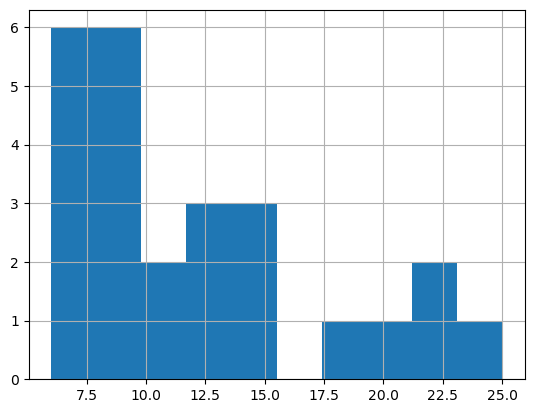

In [397]:
book_cluster_centers = np.asarray([np.mean(book_map[book_clusters == i], axis=0) for i in range(book_clusters.max() + 1)])
book_cluster_palette = datamapplot.palette_handling.palette_from_datamap(book_map, book_cluster_centers)
topic_name_palette = datamapplot.palette_handling.deep_palette(book_cluster_palette)
hostnames = selected["hostname"].unique()
hostname_palette = dict(zip(hostnames, gb.create_palette(len(hostnames))))
cluster_sizes = np.bincount(book_clusters + 1)[1:]
pd.Series(cluster_sizes).hist()

In [398]:
topics = []
K = 3
clusters_u = np.unique(book_clusters)
for cluster in tqdm(clusters_u[clusters_u != -1]):
    i_vecs_cluster, = np.nonzero(book_clusters == cluster)
    medoid = np.median(host_time_vecs[i_vecs_cluster, :], axis=0)
    dist_processes = np.inner(host_time_processes, medoid)
    i_best = np.argsort(-dist_processes)[:K]
    topics.append("\n".join(metadata_unique["process_name"].loc[i_best].drop_duplicates()))
topics

  0%|          | 0/25 [00:00<?, ?it/s]

['compattelrunner.exe',
 'msedge.exe',
 'musnotification.exe\nctfmon.exe\ntaskhostw.exe',
 'msedge.exe',
 'dsregcmd.exe\nnet.exe\nunregmp2.exe',
 'mpcmdrun.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'backgroundtaskhost.exe\ntaskhostw.exe',
 'sc.exe\nbackgroundtaskhost.exe',
 'python.exe',
 'microsoftedgeupdate.exe',
 'microsoftedgeupdate.exe',
 'logonui.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'msedge.exe',
 'upfc.exe',
 'upfc.exe\nsihclient.exe']

[[], []]

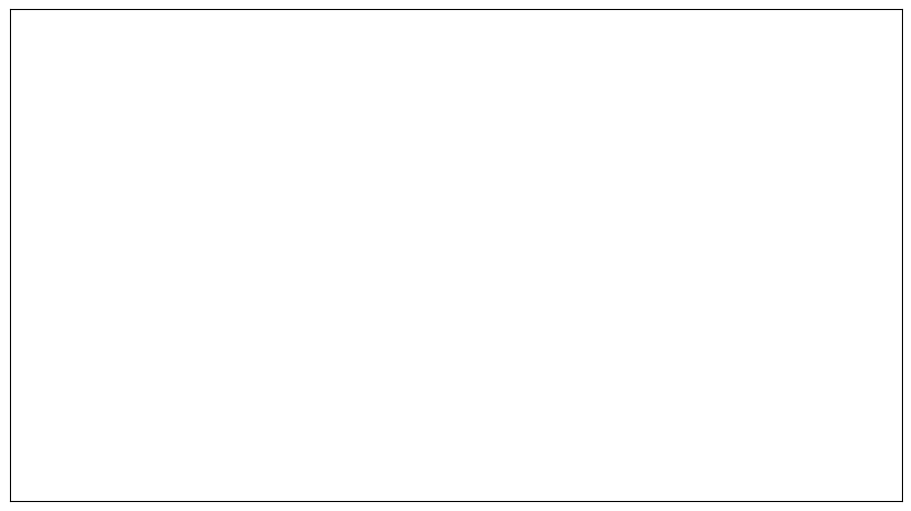

In [540]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=100, constrained_layout=True)
# ax.set_facecolor("black")
ax.scatter(*book_map.T, alpha=0.0)
ax.set(xticks=[], yticks=[])

In [400]:
font_size_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(8, 18))
font_sizes = np.squeeze(
    font_size_scaler.fit_transform(np.sqrt(cluster_sizes).reshape(-1, 1))
)
# topic_texts = []
# for cluster_num in range(book_clusters.max() + 1):
#     topic_texts.append(
#         ax.text(
#             x=book_cluster_centers[cluster_num, 0],
#             y=book_cluster_centers[cluster_num, 1],
#             s=topics[cluster_num],
#             fontsize=font_sizes[cluster_num],
#             ha="center",
#             va="center",
#             color=topic_name_palette[cluster_num],
#             # path_effects=(
#             #     [
#             #         patheffects.Stroke(linewidth=3, foreground="white"),
#             #         patheffects.Normal(),
#             #     ]
#             # )
#         )
#     )
# fig.canvas.draw()
# # pylabeladjust.adjust_texts(topic_texts, max_iterations=1000)
# ax_limits = ax.axis()

In [401]:
# n_points = 100
# subset_mask = np.hstack([np.ones(n_points, dtype=np.bool_), np.zeros(book_map.shape[0] - n_points, dtype=np.bool_)])

In [402]:
# n_points_per_frame = 10

In [541]:
from sklearn.neighbors import KernelDensity
from skimage.transform import rescale


def add_glow_to_scatterplot(
    data_map_coords,
    color_list,
    ax,
    sample_weights,
    noise_color="#999999",
    kernel_bandwidth=0.25,
    approx_patch_size=32,
    kernel="gaussian",
    n_levels=8,
    max_alpha=0.5,
):
    # we are assuming colors are hex strings!
    unique_colors = np.unique(color_list)
    color_array = np.asarray(color_list)

    for color in unique_colors:
        if color == noise_color:
            continue

        cluster_embedding = data_map_coords[color_array == color]

        # find bounds for the cluster
        xmin, xmax = (
            np.min(cluster_embedding.T[0]) - 8 * kernel_bandwidth,
            np.max(cluster_embedding.T[0]) + 8 * kernel_bandwidth,
        )
        ymin, ymax = (
            np.min(cluster_embedding.T[1]) - 8 * kernel_bandwidth,
            np.max(cluster_embedding.T[1]) + 8 * kernel_bandwidth,
        )
        width = xmax - xmin
        height = ymax - ymin
        aspect_ratio = width / height

        # Make an appropriately sized image patch
        patch_size = min(
            max(max(width, height) * approx_patch_size / 6.0, approx_patch_size), 384
        )
        patch_width = int(patch_size * aspect_ratio)
        patch_height = int(patch_size)

        # Build a meshgrid over which to evaluate the KDE
        xs = np.linspace(xmin, xmax, patch_width)
        ys = np.linspace(ymin, ymax, patch_height)
        xv, yv = np.meshgrid(xs, ys[::-1])
        for_scoring = np.vstack([xv.ravel(), yv.ravel()]).T

        # Build the KDE of the cluster
        class_kde = KernelDensity(
            bandwidth=kernel_bandwidth, kernel=kernel, atol=1e-8, rtol=1e-4
        ).fit(cluster_embedding, sample_weight=sample_weights[color_array == color])
        zv = class_kde.score_samples(for_scoring).reshape(xv.shape)
        zv = rescale(zv, 12)
        # Construct colours of varying alpha values for different levels
        alphas = [
            f"{x:02X}"
            for x in np.linspace(0, min(max_alpha, 0.1 * np.sum(sample_weights[color_array == color])) * 255, n_levels, endpoint=True).astype(
                np.uint8
            )
        ]
        level_colors = [color + alpha for alpha in alphas]

        # Create a countour plot for the image patch
        contour_data = np.exp(zv)# * np.mean(sample_weights[color_array == color])
        ax.contourf(
            contour_data,
            levels=n_levels,
            colors=level_colors,
            extent=(xmin, xmax, ymin, ymax),
            extend="max",
            origin="upper",
            antialiased=True,
            zorder=0,
        )

In [542]:
history_depth = 8
window_unit = pd.Timedelta(hours=3)
frames = pd.date_range('2023-11-05', '2023-11-21', freq=window_unit, inclusive="left", tz="UTC")
frames

DatetimeIndex(['2023-11-05 00:00:00+00:00', '2023-11-05 03:00:00+00:00',
               '2023-11-05 06:00:00+00:00', '2023-11-05 09:00:00+00:00',
               '2023-11-05 12:00:00+00:00', '2023-11-05 15:00:00+00:00',
               '2023-11-05 18:00:00+00:00', '2023-11-05 21:00:00+00:00',
               '2023-11-06 00:00:00+00:00', '2023-11-06 03:00:00+00:00',
               ...
               '2023-11-19 18:00:00+00:00', '2023-11-19 21:00:00+00:00',
               '2023-11-20 00:00:00+00:00', '2023-11-20 03:00:00+00:00',
               '2023-11-20 06:00:00+00:00', '2023-11-20 09:00:00+00:00',
               '2023-11-20 12:00:00+00:00', '2023-11-20 15:00:00+00:00',
               '2023-11-20 18:00:00+00:00', '2023-11-20 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=128, freq='3h')

In [546]:
hostname_palette = {'ACME-HH-AZH': 'darkblue'}

In [549]:
def update(frame):
    ax.clear()
    # subset_mask = np.zeros(book_map.shape[0], dtype=np.bool_)
    window = pd.DataFrame({
        "selection": np.convolve((frames == frame).astype(float), scipy.signal.windows.parzen(1 + 2 * history_depth)[:history_depth + 1]),
        "timestamp": pd.date_range(frames[0] - history_depth * window_unit, frames[-1], freq=window_unit)
    })
    selection = processes_x_host_time[["timestamp"]].merge(window, on="timestamp", how="left").fillna(0.)["selection"]
    # subset_mask = processes_x_host_time["timestamp"].between(frame - window_span, frame + window_span, inclusive="left").to_numpy()
    # sample_weight = scipy.signal.windows.parzen(np.sum(subset_mask))

    deleted_artists = list(ax.collections)
    # print(len(deleted_artists))
    for artist in ax.collections:
        artist.remove()

    ax.scatter(
        *book_map.T,
        color="#dddddd",
        alpha=selection
    )

    # for i, text in enumerate(topic_texts):
    #     text.set_alpha(np.clip(np.sum(selection[book_clusters == i]) * .75, 0.0, 1.0))
    # topic_texts = []
    selection_restricted = selection.copy()
    selection_restricted.loc[~processes_x_host_time["hostname"].isin(hostname_palette)] = 0.
    for cluster_num in range(book_clusters.max() + 1):
        ax.text(
            x=book_cluster_centers[cluster_num, 0],
            y=book_cluster_centers[cluster_num, 1],
            s=topics[cluster_num],
            fontsize=font_sizes[cluster_num],
            ha="center",
            va="center",
            color="black",
            alpha=np.clip(np.sum(selection_restricted[book_clusters == cluster_num]) * .5, 0.0, 1.0)
            # path_effects=(
            #     [
            #         patheffects.Stroke(linewidth=3, foreground="white"),
            #         patheffects.Normal(),
            #     ]
            # )
        )
    # fig.canvas.draw()
    # pylabeladjust.adjust_texts(topic_texts, max_iterations=1000)

    # subset = book_map[subset_mask]
    # color_list = [book_cluster_palette[i] if i >= 0 else "#aaaaaa44" for i in book_clusters[subset_mask]]
    # color_list = [hostname_palette[hostname] for hostname in processes_x_host_time.loc[subset_mask]["hostname"]]
    # magic_number = np.clip(128 * 4 ** (-np.log10(np.sum(subset_mask))), 0.05, 64)
    # point_scale_factor = 10
    # point_size = magic_number * (point_scale_factor / 2)
    color_list = processes_x_host_time["hostname"].map(hostname_palette)
    for hostname, color in hostname_palette.items():
        pxht = processes_x_host_time.loc[processes_x_host_time["hostname"] == hostname]
        for t in range(len(pxht) - 1):
            i, j = pxht.index[[t, t + 1]]
            x = book_map[[i, j], 0]
            y = book_map[[i, j], 1]
            alpha = np.min(selection[[i, j]])
            ax.plot(x, y, c=color, marker='o', markersize=10.*alpha, alpha=alpha, linewidth=np.clip(alpha, 0.1, 1.0))

    xmin, xmax, ymin, ymax = ax_limits
    ax.text(
        x=xmin + .05 * (xmax - xmin),
        y=ymin + .1 * (ymax - ymin),
        s=str(frame).replace(' ', '\n'),
        fontsize=12.,
        color="black",
        va="center",
        alpha=.5,
    )
    ax.axis(ax_limits)
    ax.set(xticks=[], yticks=[])

    added_artists = list(ax.collections)
    return deleted_artists + added_artists

In [550]:
%%time
# print("Animating frames ...")
# n_frames = (book_map.shape[0] - n_points) // n_points_per_frame + 1

anim = matplotlib.animation.FuncAnimation(fig=fig, func=update, frames=tqdm(frames), interval=400, blit=True, cache_frame_data=False, repeat_delay=2000)
anim.save(f"host_time.mp4")
# ax.remove()
# HTML(anim.to_html5_video())

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 33.9 s, sys: 487 ms, total: 34.4 s
Wall time: 34.5 s


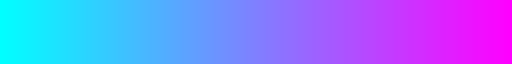

In [556]:
cmap = colormaps["cool"]
cmap

In [603]:
from sklearn.metrics.pairwise import paired_distances
from sklearn.preprocessing import Normalizer

In [568]:
book_cluster_centers[0]

array([ 3.6843543, 13.622703 ], dtype=float32)

In [604]:
paired_distances(coords, np.repeat(book_cluster_centers[0], coords.shape[0]).reshape((2, coords.shape[0])).T)

array([26.921225  , 22.387905  , 15.257747  , 23.28325   , 16.924116  ,
        0.7938959 , 16.997656  , 21.710033  , 26.893461  , 15.023776  ,
       23.745651  ,  9.517142  , 12.364404  , 17.51793   , 11.630661  ,
       11.044479  , 15.6326065 , 10.972299  , 15.685142  , 10.857855  ,
        0.09050969, 10.74073   , 11.635734  , 23.186611  , 10.965294  ,
        9.471547  , 11.409147  , 11.119527  ,  0.15443267, 15.166535  ,
       11.644241  ,  9.290748  , 10.845077  , 27.040806  , 11.436501  ,
       10.946611  ,  0.27245948, 11.135347  , 11.63036   , 15.283101  ,
       11.41653   ,  9.10325   , 10.776655  ,  9.863177  ,  0.16662645,
       11.469787  , 10.770588  , 10.524953  , 22.88078   ,  9.869085  ,
       22.34899   , 11.226223  ,  1.1956501 , 11.405533  , 11.648248  ,
        9.316762  , 10.766849  , 11.391447  , 23.309692  , 10.905876  ,
        0.31548688,  9.829459  , 11.64325   , 21.701715  , 11.439148  ,
       11.4278145 , 15.18047   , 10.182708  ,  0.14032286, 14.97

[[], []]

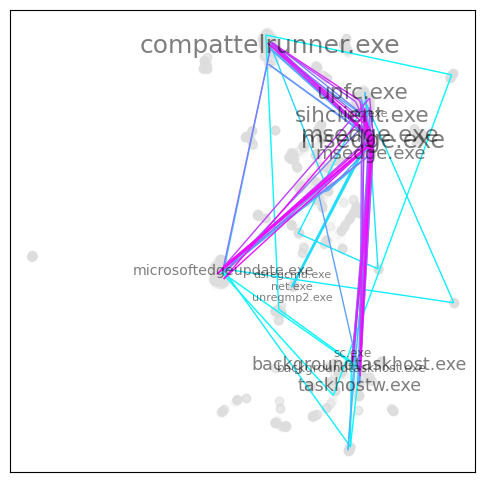

In [609]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
# ax.scatter(
#     *coords.T,
#     c=[cmap(n) for n in np.linspace(0, 1, coords.shape[0])]
# )
ax.scatter(*host_time_datamap.T, c="#dddddd", alpha=.1)

annotations = []
coords_norm = Normalizer(norm="l2").fit_transform(coords)
for cluster_num in range(book_clusters.max() + 1):
    dist_min = np.min(
        paired_distances(
            coords,
            np.repeat(
                book_cluster_centers[cluster_num],
                coords.shape[0]
            ).reshape((2, coords.shape[0])).T
        )
    )
    if dist_min < .1:
        annotations.append(
            ax.text(
                x=book_cluster_centers[cluster_num, 0],
                y=book_cluster_centers[cluster_num, 1],
                s=topics[cluster_num],
                fontsize=font_sizes[cluster_num],
                ha="center",
                va="center",
                color="black",
                alpha=.5,
                # path_effects=(
                #     [
                #         patheffects.Stroke(linewidth=3, foreground="white"),
                #         patheffects.Normal(),
                #     ]
                # )
            )
        )
fig.show()
# pylabeladjust.adjust_texts(annotations, speed=10000, max_iterations=200)
steps, increment = np.linspace(0, 1, coords.shape[0] - 1, endpoint=False, retstep=True)
for i, step in enumerate(steps):
    ax.add_patch(PathPatch(
        Path(coords[[i, i + 1]], [Path.MOVETO, Path.LINETO]),
        edgecolor=cmap(step)
    ))
ax.set(xticks=[], yticks=[])

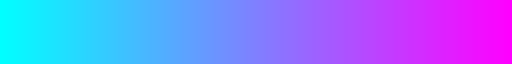

In [610]:
cmap

In [ ]:
import vectorizers as vz, vectorizers.transformers as vzt, umap, datamapplot
token_seqs = vz.BytePairEncodingVectorizer(method="sequences").fit_transform(TELEMETRY_STRINGS)
vz_cooc = vz.TokenCooccurrenceVectorizer().fit(token_seqs)
vecs_cooc = vz_cooc.reduce_dimension(DIM_COOC)  # Unsure? Use 128 🤷‍♂️
distribs_raw = vz.EdgeListVectorizer().fit_transform([
    (row, vz_cooc.token_label_dictionary_[token], count)
    for row, cc in enumerate(token_seqs)
    for token, count in zip(*np.unique(cc, return_counts=True))
])
distribs_iwt = vzt.InformationWeightTransformer().fit_transform(distribs_raw)
vecs = vz.WassersteinVectorizer().fit_transform(distribs_iwt, vectors=vecs_cooc)
datamap = umap.UMAP(metric="cosine").fit_transform(vecs)
datamapplot.create_interactive_plot(datamap, ...)